Based on:<br>
https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

### 1. Import Libraries

In [5]:
## Basic processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import calendar
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import math

## Plotting
import matplotlib
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
#sns.set_style("white")
%matplotlib inline


In [6]:
import seaborn as sns

## Statsmodel + ARIMA
import scipy.stats as scs
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots #ACF PACF

## Model Comparison
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 2. Import Data & Data Processing

In [7]:
df = pd.read_excel('PredictorData2019.xlsx', sheet_name = 0)
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m', errors='coerce').dropna()
df = df.set_index('yyyymm')
df_index = df[['Index']].dropna()
df_index['Index_FD'] = df_index["Index"].diff(1)

In [8]:
def time_series_plot (x, y, title, x_label, y_label):
    plt.figure(figsize=(12,6), dpi= 90)
    plt.plot(x, y)

    # Decoration
    plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=12, alpha=.7)
    plt.title(title, fontsize=17)
    plt.xlabel(x_label, size = 13)
    plt.ylabel(y_label, size = 13)
    plt.grid(axis='both', alpha=.3)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    #plt.savefig(fig_name)
    plt.show()

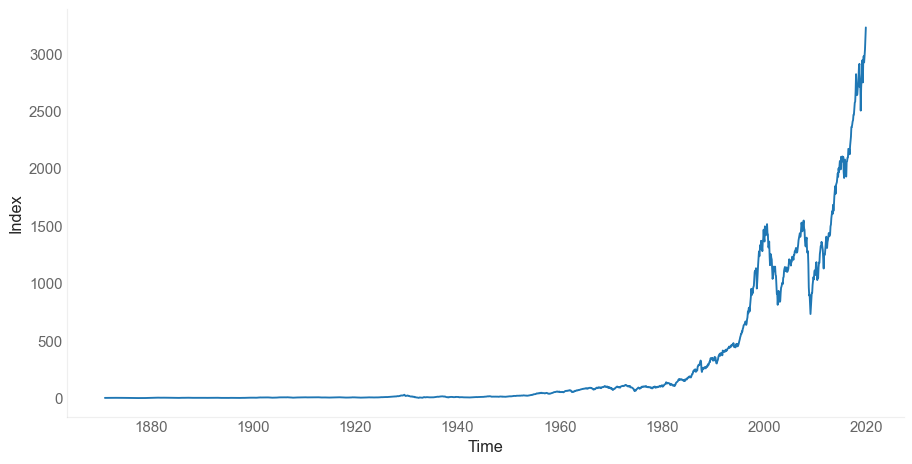

In [9]:
time_series_plot (x = df_index.index, y = df_index['Index'].values, title = None, x_label = 'Time', y_label = 'Index')

### 3. Checking for stationarity

#### 3.1. Rolling Mean and Std.

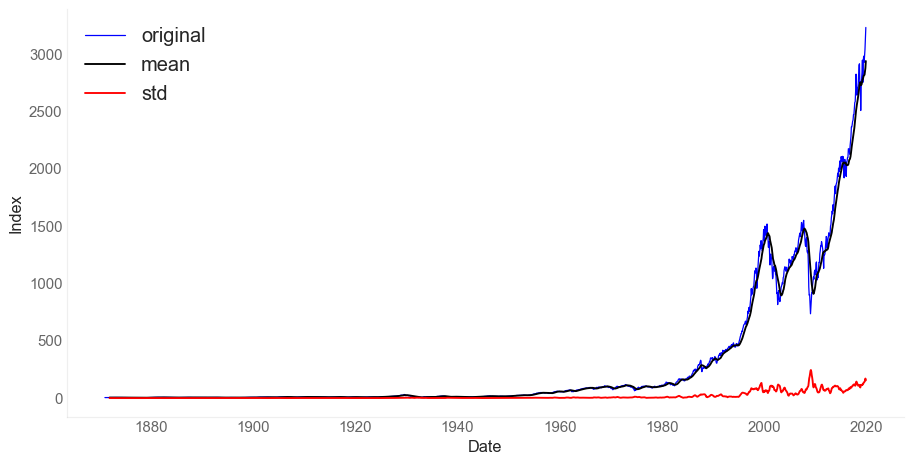

In [10]:
def mean_std_plot (df, col):
    x_label = 'Date'
    y_label = 'Index'
    x = df.index
    plt.figure(figsize=(12,6), dpi= 90)
    y1 = df[col].values
    y2 = df[col].rolling(12).mean()
    y3 = df[col].rolling(12).std()
    plt.plot(x, y1, color ='blue', linewidth=1, label = 'original')
    plt.plot(x, y2, color ='black', linewidth=1.5, label = 'mean')
    plt.plot(x, y3, color = 'red', label = 'std')
    plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel(x_label, size = 13)
    plt.ylabel(y_label, size = 13)
    plt.grid(axis='both', alpha=.3)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    plt.legend()
    #plt.savefig(save_fig)
    plt.show()
    
mean_std_plot(df = df_index, col = 'Index')

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

#### 3.2. Test for Stationarity

In [11]:
def test_stationarity(df, ts):
    ## Perform Dickey-Fuller test:
    dftest = adfuller(df[ts], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
        
    ## KPSS-Test
    df_kpss = np.array(df[ts])
    kpss_result = list(kpss(df_kpss))
     
    print ("Results - Dickey fuller test")
    print (dfoutput)
    print ()
    print ('----------------------------------')
    print ('Results - KPSS Test')
    print ('Test Statistic:', round(kpss_result[0], 5))
    print ('p-value:', kpss_result[1])

In [12]:
test_stationarity(df = df_index, ts = 'Index')

Results - Dickey fuller test
Test Statistic                    4.953842
p-value                           1.000000
# Lags Used                      22.000000
Number of Observations Used    1765.000000
Critical Value (1%)              -3.434060
Critical Value (5%)              -2.863179
Critical Value (10%)             -2.567643
dtype: float64

----------------------------------
Results - KPSS Test
Test Statistic: 3.6155
p-value: 0.01


We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values, so the data is non-stationary. In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

#### 3.3. Time-Series decomposition

In [15]:
def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(ts))
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

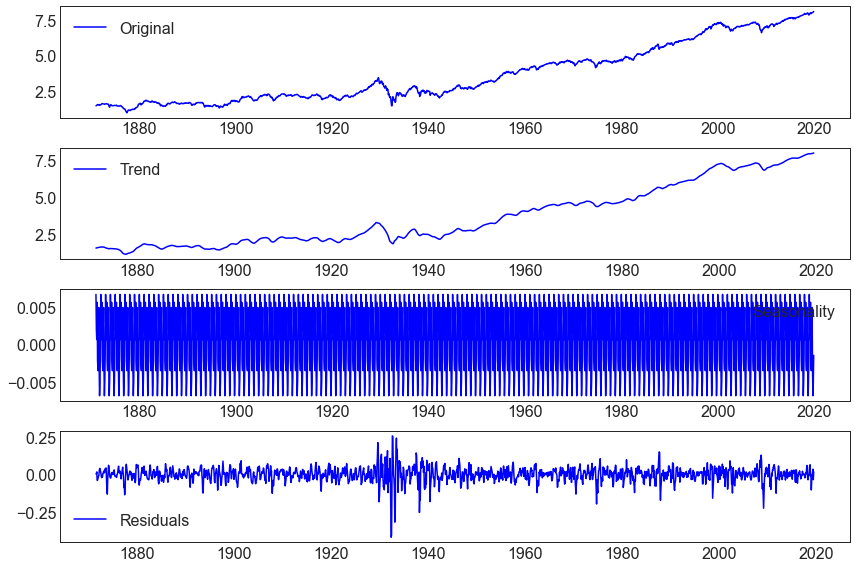

In [33]:
index_values = df_index[['Index']].dropna()
decomposition_plot(index_values)

#### 3.4. Make time-series stationary

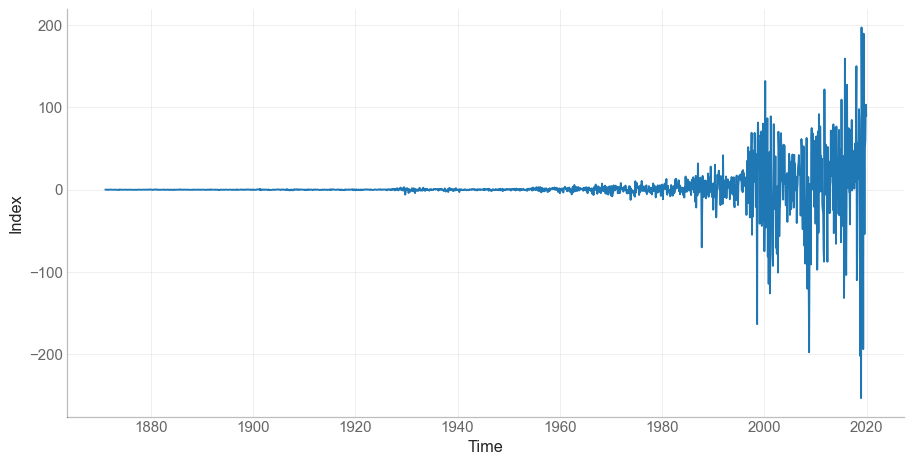

In [34]:
time_series_plot(x = df_index.index, y = df_index['Index_FD'].values,  title = None, 
                 x_label = 'Time', y_label = 'Index')

#### 3.5. Check for stationarity of the differenced time-series

In [35]:
df_index_fd = df_index[['Index_FD']].dropna()
test_stationarity(df = df_index_fd, ts = 'Index_FD')

Results - Dickey fuller test
Test Statistic                -6.905407e+00
p-value                        1.250973e-09
# Lags Used                    2.100000e+01
Number of Observations Used    1.765000e+03
Critical Value (1%)           -3.434060e+00
Critical Value (5%)           -2.863179e+00
Critical Value (10%)          -2.567643e+00
dtype: float64

----------------------------------
Results - KPSS Test
Test Statistic: 1.25346
p-value: 0.01


### 4. ARMA Modelling

#### 4.1. Train-Test split

In [36]:
#split data into train and training set
train_data = df_index_fd[(df_index_fd.index >= '1871-01-01') & (df_index_fd.index <= '2016-12-01')]
test_data = df_index_fd[(df_index_fd.index >= '2017-01-01') & (df_index_fd.index <= '2019-12-01')]

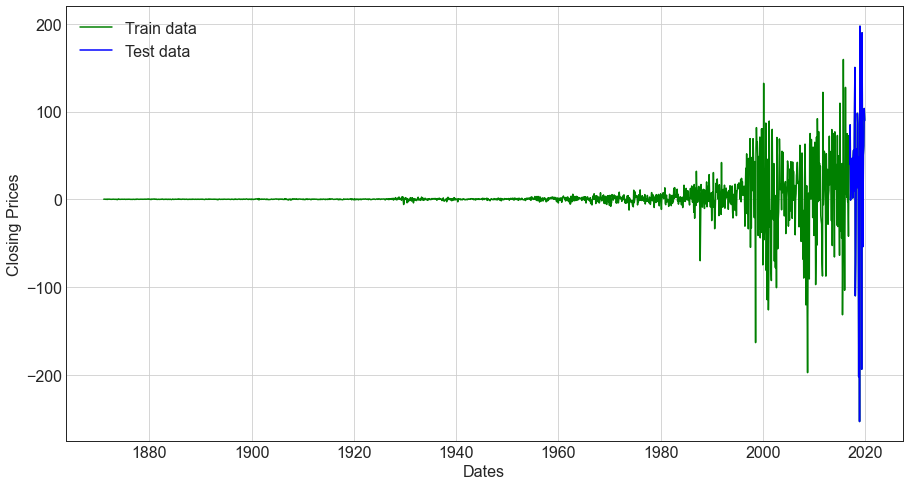

In [37]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_index_fd, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

#### 4.2. Choosing the best model

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

In [38]:
stepwise_fit = auto_arima(train_data, start_p=0, start_q=0, max_p=10, max_q=10, m=7, test = 'adf',
                          start_P=0, seasonal=False, d=0, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,  
                          stepwise=False, stationary = True)  

print (stepwise_fit.summary())

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15571.338, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15570.896, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15567.029, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=15557.741, Time=0.36 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=15553.294, Time=0.59 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=15539.698, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15571.181, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15562.497, Time=0.59 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=15540.628, Time=0.75 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=15542.145, Time=1.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=15567.562, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15563.096, Time=0.63 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15535.231, Time=1.43 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=15542.119, Time=0.83 sec
 

#### 4.3. Fitting model

In [39]:
model = ARIMA(train_data, order=(7, 0, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:               Index_FD   No. Observations:                 1751
Model:                     ARMA(7, 2)   Log Likelihood               -7740.937
Method:                       css-mle   S.D. of innovations             20.086
Date:                Tue, 06 Apr 2021   AIC                          15503.874
Time:                        14:07:18   BIC                          15564.022
Sample:                    02-01-1871   HQIC                         15526.108
                         - 12-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.2841      0.610      2.106      0.035       0.089       2.479
ar.L1.Index_FD    -0.3126      0.024    -12.858      0.000      -0.360      -0.265
ar.L2.Index_FD    -1.0251      0.025

#### 4.4. Checking residuals of fitted model

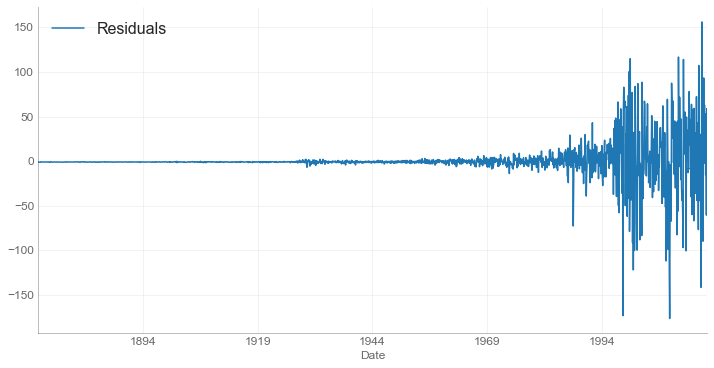

In [40]:
residuals = pd.DataFrame(fitted.resid)
residuals.columns = ['Residuals']
residuals.plot(figsize=(12,6), label='Residuals')

# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.xlabel('Date', alpha = 0.70, fontsize = 12)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)
plt.legend(loc='upper left');
plt.show()

#### 4.5. Model Forecasting

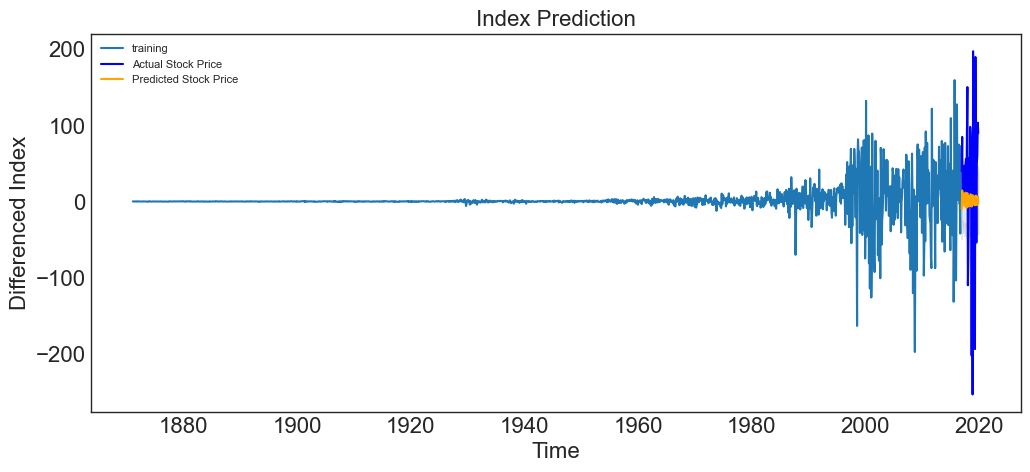

In [41]:
fc, se, conf = fitted.forecast(36, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Index Prediction')
plt.xlabel('Time')
plt.ylabel('Differenced Index')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 9612.80295415064
MAE: 74.7339160849754
RMSE: 98.04490274435811
